Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [1]:
# Import items

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [8]:
# Read in data and store in df_voles

df_voles = pd.read_csv("http://bit.ly/2IgDF0E")

Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [9]:
# Use the .head() method to preview the data

df_voles.head()

,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

In [110]:
# Set up some colors

carolinaBlue = "#7BAFD4"
carolinaNavy = "#13294B"
campusSandstone = "#F4E8DD"

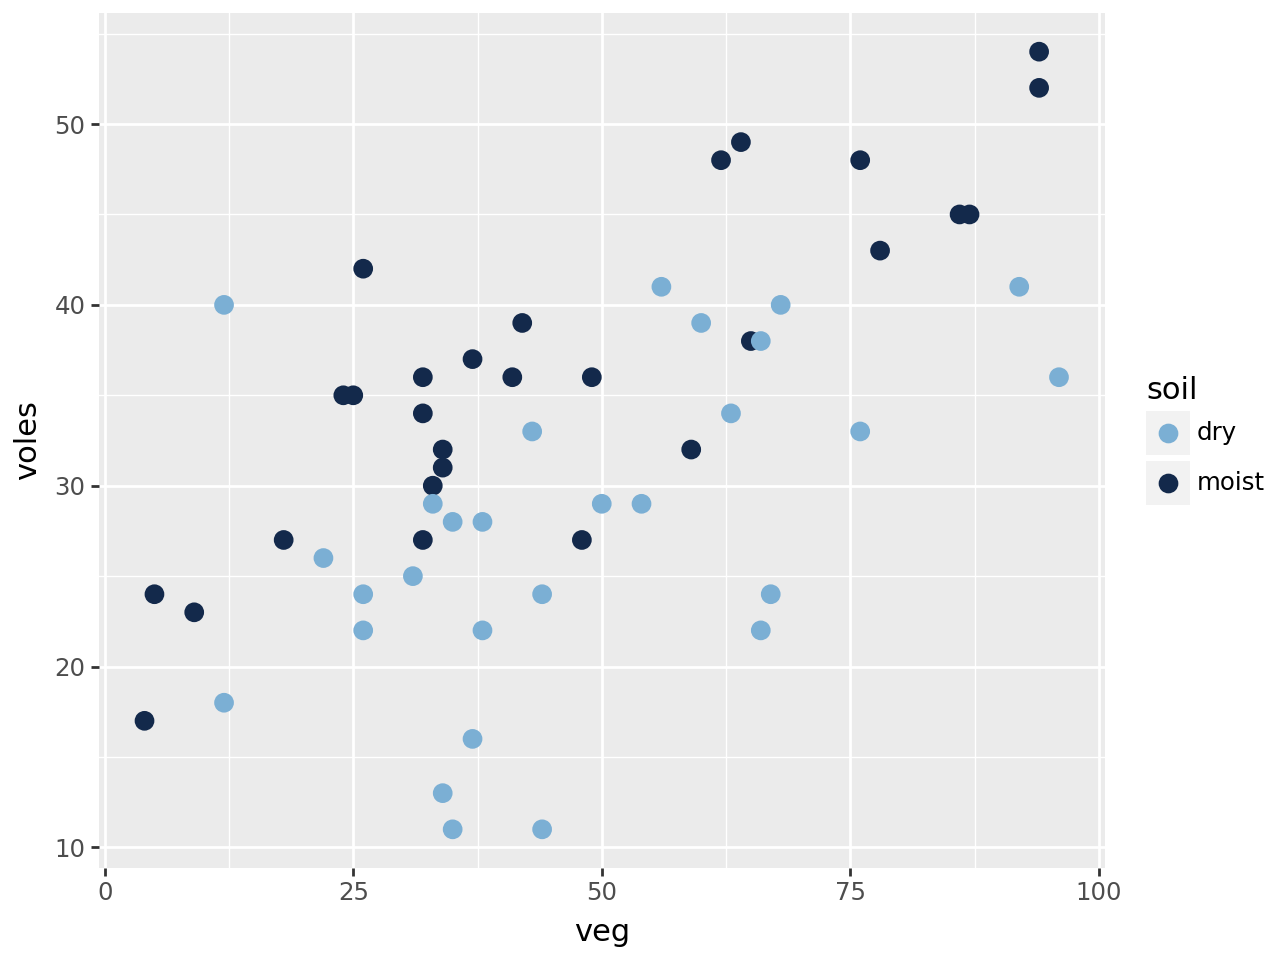

In [33]:
# Using the grammar of graphics from Plotnine

(
    ggplot(df_voles, aes("veg", "voles", color = "soil")) 
    + geom_point(size = 3)
    + scale_color_manual(values = [carolinaBlue, carolinaNavy])
)

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [22]:
# Model voles with soil and veg as predictors in a parallel slopes model

# Make a column transformer // a preprocessor to dummy encode the soil variable
ct = make_column_transformer(
    ['passthrough', ['veg']],
    [OneHotEncoder(drop="first"), ['soil']]
)

# Create a pipeline/model
pl = make_pipeline(
    ct,
    LinearRegression()
)

# Create the outcome variable
outcome = 'voles'

# Create training and test data
X, y = df_voles.loc[:, df_voles.columns != outcome], df_voles[outcome]

# Train the model using the .fit() method with the pipeline
pl.fit(X, y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['veg']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil'])])),
                ('linearregression', LinearRegression())])

In [27]:
# Predict values and assign as new column to dataframe

df_voles = df_voles.assign(predict_voles = pl.predict(X))

In [28]:
df_voles.head()

,site,voles,veg,soil,predict_voles
0,1,17,4,moist,25.600600
1,2,30,33,moist,33.113599
2,3,54,94,moist,48.916804
3,4,49,64,moist,41.144736
4,5,34,32,moist,32.854530


In [53]:
# Wanting to use a custom marker in the plot: 'v' for voles 🐁

df_voles['marker'] = 'v'

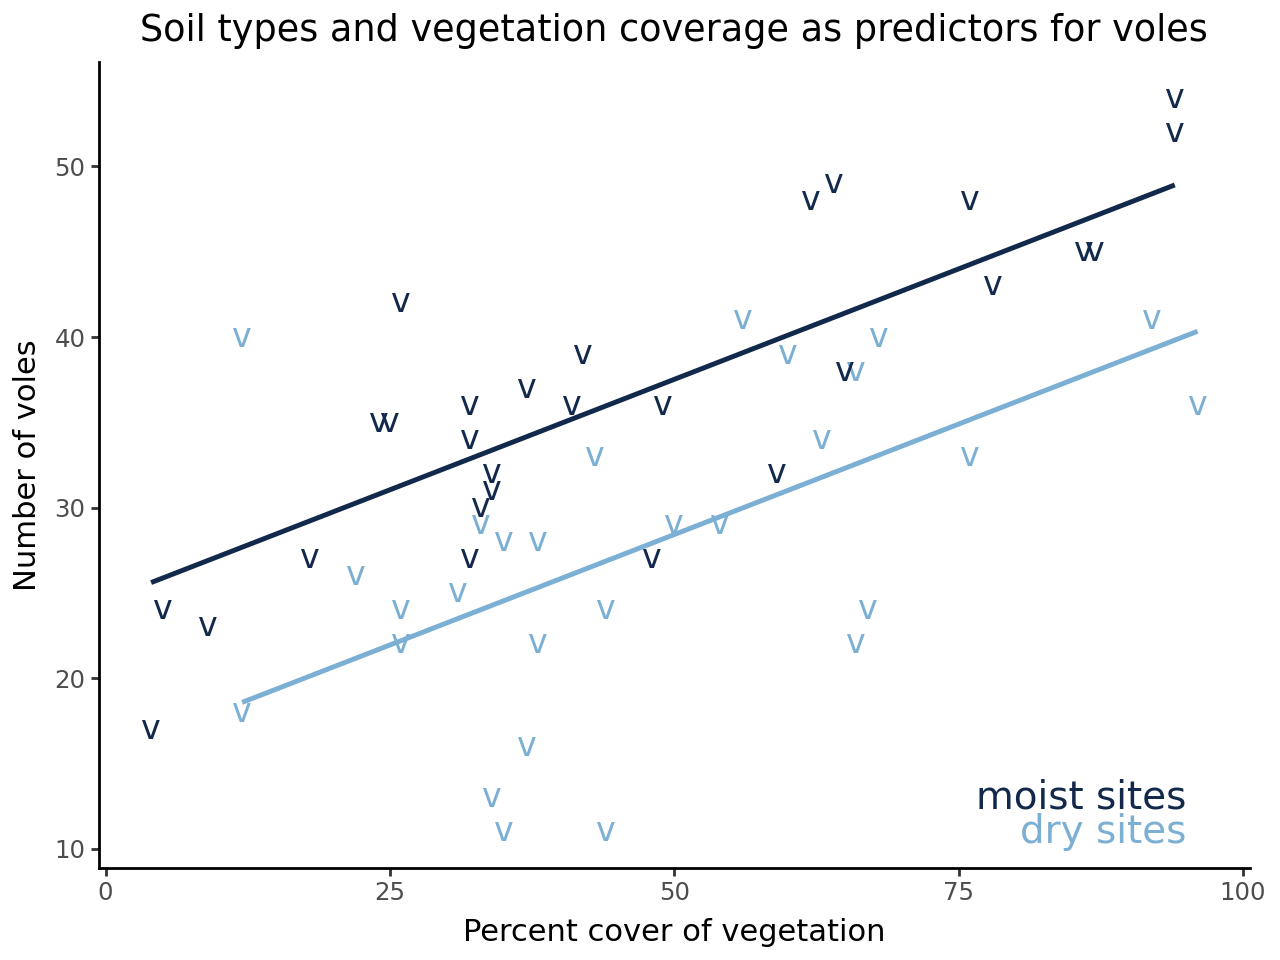

In [107]:
(
    ggplot(df_voles, aes('veg', 'voles', color='soil'))
    + geom_point(alpha=0)
    + geom_text(aes(label='marker'), size=12) # Using letter 'v' as custom marker for voles
    + geom_line(aes(y='predict_voles', group='soil'), size=1)
    + scale_color_manual(values=[carolinaBlue, carolinaNavy])
    + xlab("Percent cover of vegetation")
    + ylab("Number of voles")
    + labs(title="Soil types and vegetation coverage as predictors for voles")
    + annotate('text', x=max(df_voles['veg']) - 1, y=min(df_voles['voles']), label='dry sites', color=carolinaBlue, size=14, ha='right')
    + annotate('text', x=max(df_voles['veg']) - 1, y=min(df_voles['voles']) + 2, label='moist sites', color=carolinaNavy, size=14, ha='right')
    + theme(
        legend_position='none',
        panel_background=element_blank(),
        axis_line_x=element_line(color='black'),
        axis_line_y=element_line(color='black')
    )
)

Use the function below to get the parameter values for your model from above.

In [103]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

In [104]:
get_regression_table(pl)

,term,estimate
0,passthrough__veg,0.259069
1,onehotencoder__soil_moist,9.100298
2,intercept,15.464026


❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

💡The data model shows that increasing vegetation cover corresponds to a higher vole population, so protecting sites with high vegetation cover would be more effective in preserving vole populations than sites with low vegetation cover.

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

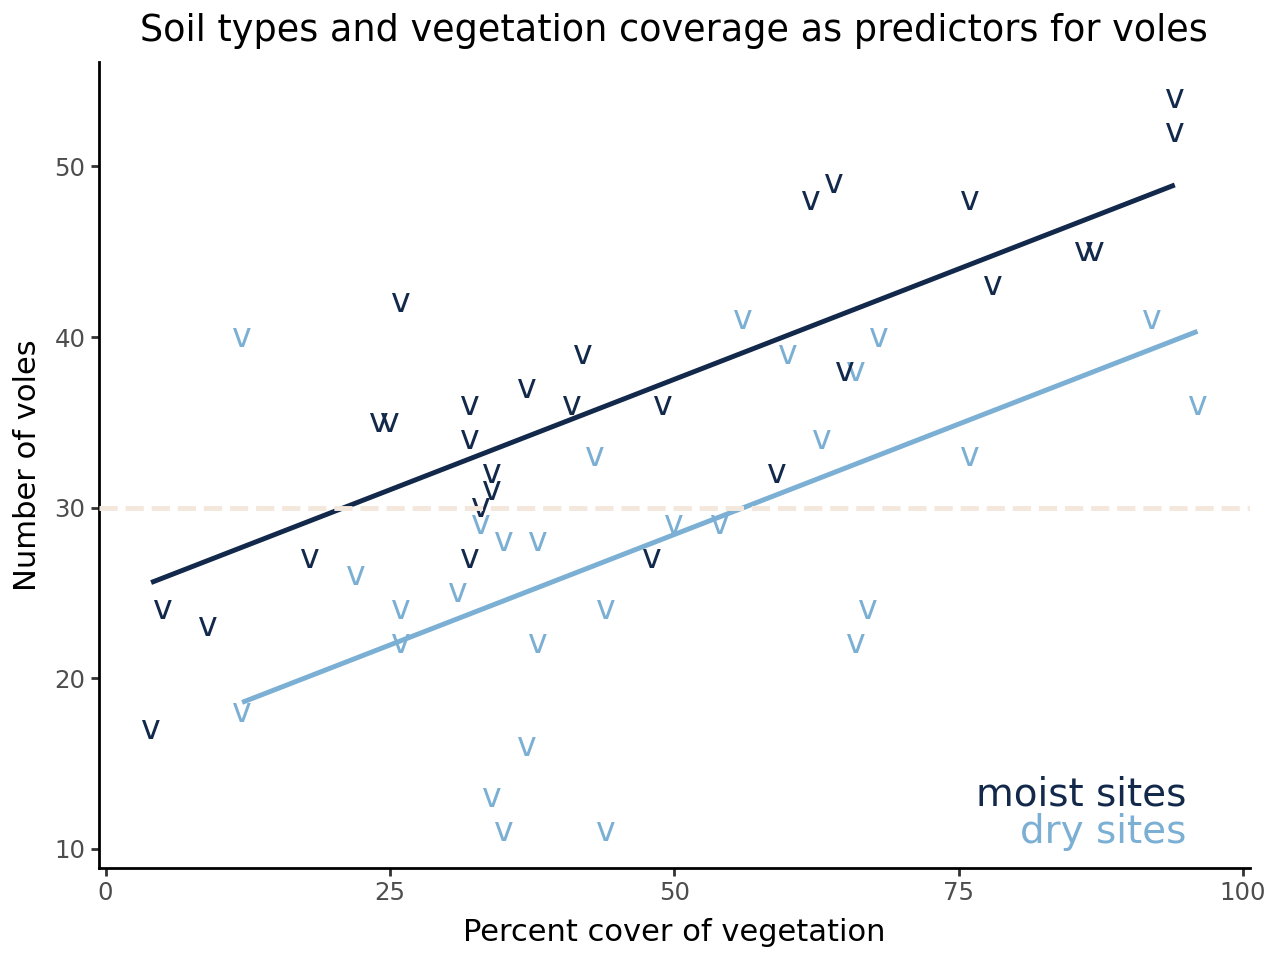

In [120]:
# Use a horizontal line at voles = 30 to roughly estimate percent cover of vegetation
# Needed to support a population of about 30 voles at the site

(
    ggplot(df_voles, aes('veg', 'voles', color='soil'))
    + geom_point(alpha=0)
    + geom_text(aes(label='marker'), size=12) # Using letter 'v' as custom marker for voles
    + geom_line(aes(y='predict_voles', group='soil'), size=1)
    + scale_color_manual(values=[carolinaBlue, carolinaNavy])
    + xlab("Percent cover of vegetation")
    + ylab("Number of voles")
    + labs(title="Soil types and vegetation coverage as predictors for voles")
    + geom_hline(yintercept = 30, color=campusSandstone, size=1, linetype='dashed')
    + annotate('text', x=max(df_voles['veg']) - 1, y=min(df_voles['voles']), label='dry sites', color=carolinaBlue, size=14, ha='right')
    + annotate('text', x=max(df_voles['veg']) - 1, y=min(df_voles['voles']) + 2.2, label='moist sites', color=carolinaNavy, size=14, ha='right')
    + theme(
        legend_position='none',
        panel_background=element_blank(),
        axis_line_x=element_line(color='black'),
        axis_line_y=element_line(color='black')
    )
)

**Answer:**

💡The conservation organization should plan to maintain roughly 55-60% minimum vegetation cover at the dry sites they acquire to support a population of 30 voles in these locations. 🐁

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with your pipeline.)

In [127]:
# Use the regression pipeline to predict the possible vole population at the site with these requirements

# creates a single-valued array
question_requirements = pl.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))

# indexing to retrieve the predicted value
print(question_requirements[0])

34.92708150903549


**Answer:**

💡The regression model predicts that a site with moist soil and 40% vegetation cover could possibly support a vole population of about 35. Checking the plot above, there are some data points in that area. This result is plausible.